# Finding Ocean Eddies using Satellite Altimetry: Part 2

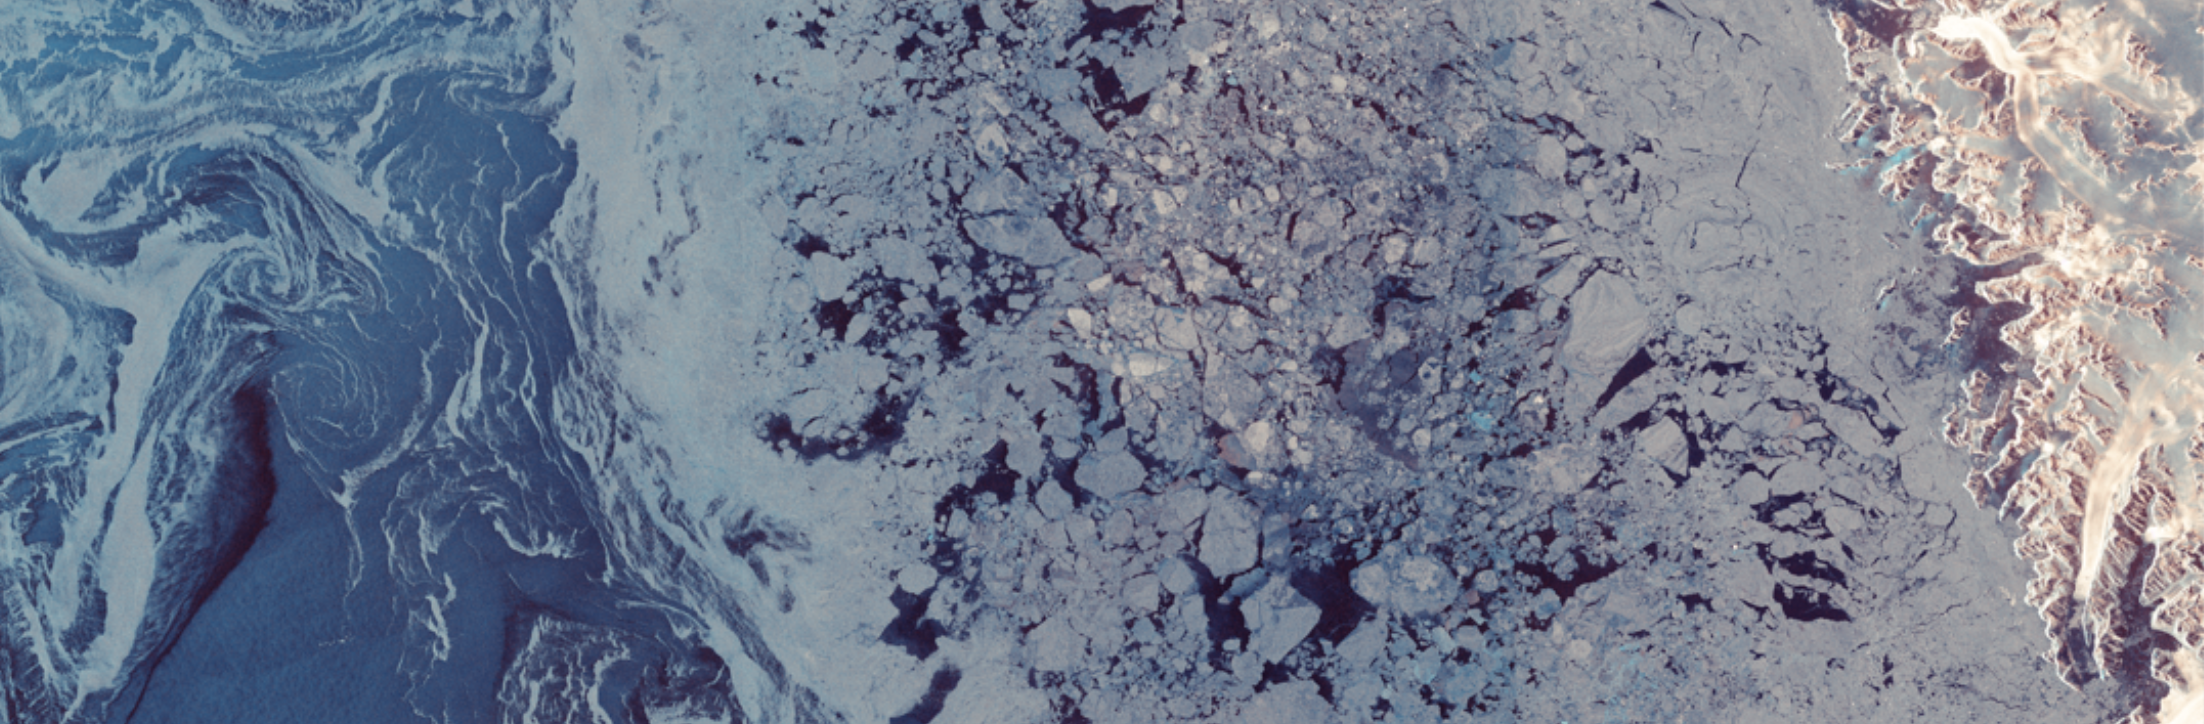

In Part 1 of "Finding Ocean Eddies using Satellite Altimetry", we explored the AVISO+ Mesoscale Eddy Trajectory Atlas (META3.2 DT) to identify a significant eddy within a region and timeframe of interest. After selecting a target eddy, we extracted its key parameters and retrieved Sentinel-3 altimetry data within a defined buffer zone around it.

In Part 2 of this study, we will use GPSat to optimally interpolate the sea surface height anomaly (SSHA) derived from Sentinel-3 data in attempt to reconstruct our selected eddy.

## Install and load GPSat and the required packages

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = True

if IN_COLAB:
    import sys
    import os
    import re

    # change to working directory
    work_dir = os.getcwd()

    assert os.path.exists(work_dir), f"workspace directory: {work_dir} does not exist"
    os.chdir(work_dir)

    # clone repository
    ! git clone https://github.com/CPOMUCL/GPSat.git

    repo_dir = os.path.join(work_dir, "GPSat")

    print(f"changing directory to: {repo_dir}")
    os.chdir(repo_dir)

    ! pip install -r requirements.txt

    ! pip install -e .

    ! pip install --upgrade pandas

    print(f"changing directory back to: {work_dir}")
    os.chdir(work_dir)

    sys.path.append(os.path.join(repo_dir, "GPSat"))


Cloning into 'GPSat'...
remote: Enumerating objects: 2873, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 2873 (delta 143), reused 253 (delta 139), pack-reused 2601 (from 1)
Receiving objects: 100% (2873/2873), 59.92 MiB | 13.75 MiB/s, done.
Resolving deltas: 100% (1959/1959), done.
changing directory to: /content/GPSat
Ignoring setuptools: markers 'python_version >= "3.12"' don't match your environment
Ignoring tensorflow: markers 'platform_system == "Darwin" and platform_machine == "x86_64"' don't match your environment
Ignoring tensorflow-macos: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
Ignoring gpflow: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
INFO: pip is looking at multiple versions of xarray to determine which version is compatible with other requirements. This could take a while.
INFO: pip is st

In [ ]:
gpsat_repo_dir = os.path.join(os.getcwd(), "GPSat/")
sys.path.append(gpsat_repo_dir)
import sys
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj, transform
from pathlib import Path
from scipy.spatial import KDTree
from GPSat import get_data_path, get_parent_path
from GPSat.dataprepper import DataPrep
from GPSat.utils import WGS84toEASE2_New, EASE2toWGS84_New, cprint, grid_2d_flatten, get_weighted_values
from GPSat.local_experts import LocalExpertOI, get_results_from_h5file
from GPSat.plot_utils import plot_pcolormesh, get_projection, plot_pcolormesh_from_results_data
from GPSat.config_dataclasses import DataConfig, ModelConfig, PredictionLocsConfig, ExpertLocsConfig
from GPSat.postprocessing import glue_local_predictions_2d
from global_land_mask import globe
import matplotlib.lines as mlines

## Set paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
week8_path = Path('/content/drive/MyDrive/GEOL0069/2425/Week 8')

## Load our selected eddy

In [ ]:
#Load the selected eddy data
eddy_number = 718441
date = pd.to_datetime("2019-01-18").date()
#load the selected eddy
selected_eddy = gpd.read_file(week8_path / f"selected_eddy_{date}_{eddy_number}.gpkg", layer='row')

In [ ]:
selected_eddy

In [ ]:
#The eddy coords use the 0-360 longitude convention, let's change them to -180 to 180 for consistency with the EPSG:4326 projection

from shapely.geometry import Polygon

# Function to shift longitudes from 0-360 to -180 to 180
def shift_longitude(geometry):
    if geometry.geom_type == "Polygon":
        new_coords = [((lon - 360 if lon > 180 else lon), lat) for lon, lat in geometry.exterior.coords]
        return Polygon(new_coords)
    elif geometry.geom_type == "MultiPolygon":
        new_polygons = []
        for poly in geometry.geoms:
            new_coords = [((lon - 360 if lon > 180 else lon), lat) for lon, lat in poly.exterior.coords]
            new_polygons.append(Polygon(new_coords))
        return gpd.GeoSeries(new_polygons).unary_union  # Convert list back to MultiPolygon
    return geometry

selected_eddy["geometry"] = selected_eddy["geometry"].apply(shift_longitude)
selected_eddy = selected_eddy.set_crs('EPSG:4326')


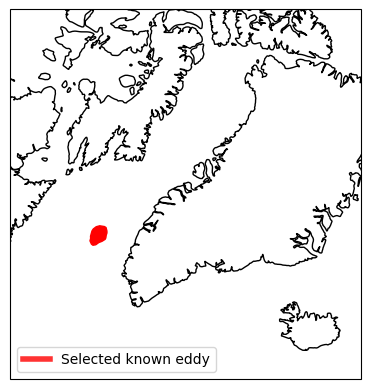

In [ ]:
#plot the selected eddy location
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-25, -90, 60, 80], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_geometries([selected_eddy.geometry.iloc[0]], crs=ccrs.PlateCarree(), facecolor='red', edgecolor='red')
eddy_proxy = mlines.Line2D([], [], color='red', linewidth=4, alpha=0.8, label="Selected known eddy")
ax.legend(handles=[eddy_proxy], loc='lower left')
plt.show()

## Load the Sentinel-3 altimetry data and compute SSHA

Sea Surface Height Anomaly (SSHA) represents the deviation of the instantaneous sea surface height (SSH) from a long-term mean sea surface (MSS). It provides insights into ocean circulation, mesoscale eddies, and sea level variability, making it a key parameter in altimetry-based ocean studies.

SSHA is calculated as:

$$
\text{SSHA} = \text{SSH} - \text{MSS}
$$

where:

SSH (Sea Surface Height) is the instantaneous height of the sea surface measured by the satellite altimeter.
MSS (Mean Sea Surface) represents the long-term average sea surface height, derived from multi-year satellite observations.
SSHA is particularly useful for detecting dynamic ocean features, such as eddies, currents, and tides, as it removes the static component of the sea surface height, revealing short-term variability.

The Sentinel-3 product we will be using in this practical does not include SSH derived from the ideal opean ocean retracker (SAMOSA). We therefore need to compute it from the SAMOSA-retracked range to the water surface, including correcting for geophysical effects contaminating our signal.

SSHA is therefore calculated as:

***SSH = H - R - C***

$$
\text{SSH} = \text{H} - \text{R} - \text{C}
$$

where:

H = Satellite Altitude

R = Ku-band retracked range to water

C = Geophysical Corrections, which include:
Ionospheric correction, dry tropospheric correction,
wet tropospheric corrections, sea state bias correction,
tidal corrections, inverted barometer correction high-frequency sea surface fluctuation correction



In [ ]:
def add_sea_surface_height_and_anomaly(sral_ds):
    """
    Calculate the sea surface height anomaly from a Sentinel-3 SRAL dataset.
    Based on the L2 WAT definition:
    SSHA = altitude of satellite (alt_20_ku) - Ku band corrected ocean altimeter range (range_ocean_20_ku)
    - filtered altimeter ionospheric correction on Ku band (iono_cor_alt_filtered_01_ku)
    - model dry tropospheric correction (mod_dry_tropo_cor_zero_altitude_01)
    - radiometer wet tropospheric correction (rad_wet_tropo_cor_01_ku)
    - sea state bias correction in Ku band (sea_state_bias_01_ku)
    - solid earth tide height (solid_earth_tide_01)
    - geocentric ocean tide height solution 2 = FES (ocean_tide_sol2_01)
    - geocentric pole tide height (pole_tide_01)
    - inverted barometer height correction (inv_bar_cor_01)
    - high frequency fluctuations of the sea surface topography (hf_fluct_cor_01 for NTC/STC off line products only)
    - mean sea surface (mean_sea_surf_sol2_20_ku)"

    Parameters:
    sral_ds (xarray.Dataset): The Sentinel-3 SRAL dataset.
    Returns:
    The Sentinel-3 SRAL dataset with the calculated sea surface height and sea surface height anomaly.
    """

    #Before we can calculate the sea surface height anomaly (SSHA), we need to interpolate the 1Hz corrections to the 20Hz data
    mod_dry_tropo_cor_zero_altitude_20_ku = sral_ds.mod_dry_tropo_cor_zero_altitude_01.interp(time_01=sral_ds.time_20_ku)
    iono_cor_alt_filtered_20_ku = sral_ds.iono_cor_alt_filtered_01_ku.interp(time_01=sral_ds.time_20_ku)
    rad_wet_tropo_cor_20_ku = sral_ds.rad_wet_tropo_cor_01_ku.interp(time_01=sral_ds.time_20_ku)
    sea_state_bias_20_ku = sral_ds.sea_state_bias_01_ku.interp(time_01=sral_ds.time_20_ku)
    solid_earth_tide_20_ku = sral_ds.solid_earth_tide_01.interp(time_01=sral_ds.time_20_ku)
    ocean_tide_sol2_20_ku = sral_ds.ocean_tide_sol2_01.interp(time_01=sral_ds.time_20_ku)
    pole_tide_20_ku = sral_ds.pole_tide_01.interp(time_01=sral_ds.time_20_ku)
    inv_bar_cor_20_ku = sral_ds.inv_bar_cor_01.interp(time_01=sral_ds.time_20_ku)
    hf_fluct_cor_20_ku = sral_ds.hf_fluct_cor_01.interp(time_01=sral_ds.time_20_ku)

    # Calculate the sea surface height
    ssh = sral_ds.alt_20_ku - sral_ds.range_water_20_ku - iono_cor_alt_filtered_20_ku - mod_dry_tropo_cor_zero_altitude_20_ku - rad_wet_tropo_cor_20_ku - sea_state_bias_20_ku - solid_earth_tide_20_ku - ocean_tide_sol2_20_ku - pole_tide_20_ku - inv_bar_cor_20_ku - hf_fluct_cor_20_ku

    ssh.attrs = {
        "long_name": "Sea Surface Height",
        "units": "m",
        "standard_name": "sea_surface_height_above_sea_leved",
        "comment": "Calculated as SSH = altitude of satellite (alt_20_ku) - Ku band corrected ocean altimeter range (range_ocean_20_ku) - filtered altimeter ionospheric correction on Ku band (iono_cor_alt_filtered_01_ku) - model dry tropospheric correction (mod_dry_tropo_cor_zero_altitude_01) - radiometer wet tropospheric correction (rad_wet_tropo_cor_01_ku) - sea state bias correction in Ku band (sea_state_bias_01_ku) - solid earth tide height (solid_earth_tide_01) - geocentric ocean tide height solution 2 = FES (ocean_tide_sol2_01) - geocentric pole tide height (pole_tide_01) - inverted barometer height correction (inv_bar_cor_01) - high frequency fluctuations of the sea surface topography (hf_fluct_cor_01 for NTC/STC off line products only)"
    }

    sral_ds['ssh_20_ku'] = ssh

    # Calculate the sea surface height anomaly
    ssha = ssh - sral_ds.mean_sea_surf_sol2_20_ku

    ssha.attrs = {
        "long_name": "Sea Surface Height Anomaly",
        "units": "m",
        "standard_name": "sea_surface_height_above_sea_leved",
        "comment": "Calculated as SSHA = ssha - mean sea surface (mean_sea_surf_sol2_20_ku)"
    }

    sral_ds['ssha_20_ku'] = ssha

    return sral_ds

Let's iterate through the Sentinel-3 SRAL data we downloaded in part 1 of this practical, load it, calculate the SSH and SSHA, and do some filtering to reduce the memory load

In [ ]:
eddy_sral_dir = week8_path / 'S3_SRAL' / f'Eddy_num_{eddy_number}'

#load in the data
sral_filepaths = list(eddy_sral_dir.glob('**/*enhanced_measurement.nc'))
vars_of_interest = ['ssha_20_ku', 'ssh_20_ku', 'range_water_20_ku', 'alt_20_ku', 'sea_ice_ssha_20_ku', 'int_sea_ice_ssha_20_ku', 'mean_sea_surf_sol2_20_ku', 'sea_ice_sea_surf_20_ku', 'surf_type_class_20_ku', 'sea_ice_concentration_20_ku', 'freeboard_20_ku', 'dist_coast_20_ku']
sral_datasets = []
for sral_filepath in sral_filepaths:
    ds = xr.open_dataset(sral_filepath)
    ds = add_sea_surface_height_and_anomaly(ds)
    ds = ds[vars_of_interest]
    #crop to 50deg N
    ds = ds.where(ds.lat_20_ku >= 50, drop=True)
    #buffer by coast
    ds = ds.where(ds.dist_coast_20_ku >= 25e3, drop=True)
    sral_datasets.append(ds)
sral_ds = xr.concat(sral_datasets, dim='time_20_ku')

del sral_datasets, ds

Now we can define our training window for GPSat and ensure that the S3 data we have only covers the relevant dates. We will also filter out any obvious SSHA outliers (> 1m in amplitude)

In [ ]:
training_window = pd.Timedelta(days=7)
#Crop the sral data to the date ± training window
sral_ds = sral_ds.where((sral_ds.time_20_ku.dt.date >= date - training_window) & (sral_ds.time_20_ku.dt.date <= date + training_window), drop=True)

#set to nan any sshas > 1m
sral_ds['ssha_20_ku'] = sral_ds['ssha_20_ku'].where(((sral_ds['ssha_20_ku'] <= 1) & (sral_ds['ssha_20_ku'] >= -1)), np.nan)

Plot some of the key variables relevant to this practical. Note that the dataset also includes sea_ice_ssha_20_ku and int_sea_ice_20_ku, which represent the sea surface height anomaly (SSHA) and interpolated SSHA over sea ice, respectively. These variables are derived using a specialised retracking algorithm for the sea ice environment. However, in this study, we have chosen to use the SAMOSA retracker and compute SSHA ourselves, as SAMOSA is targeted toward open ocean applications, likely providing more accurate sea level estimates in non-ice-covered regions.

In [ ]:

#Plot each of the variables of interest in the general vicinity of the eddy
vars_to_plot = ['sea_ice_concentration_20_ku', 'mean_sea_surf_sol2_20_ku', 'ssh_20_ku', 'ssha_20_ku', 'sea_ice_ssha_20_ku', 'int_sea_ice_ssha_20_ku', 'sea_ice_sea_surf_20_ku']

%matplotlib inline
fig, axs = plt.subplots(3, 3, figsize=(18, 15), subplot_kw={'projection': ccrs.NorthPolarStereo()})
axs = axs.flatten()
eddy_proxy = mlines.Line2D([], [], color='black', linewidth=2, linestyle='--', alpha=0.8, label="Selected known eddy")
for i, var in enumerate(vars_to_plot):
    ax = axs[i]
    ax.set_extent([-15, -70, 55, 85], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.gridlines(alpha=0.5)
    if 'ssha' in var:
        sm = ax.scatter(sral_ds['lon_20_ku'], sral_ds['lat_20_ku'], c=sral_ds[var], cmap='coolwarm', transform=ccrs.PlateCarree(), s=1, vmin=-0.5, vmax=0.5)
    else:
        sm = ax.scatter(sral_ds['lon_20_ku'], sral_ds['lat_20_ku'], c=sral_ds[var], cmap='jet', transform=ccrs.PlateCarree(), s=1)
    cbar_label = sral_ds[var].long_name.split(': 20 Hz Ku band')[0]
    if 'units' in sral_ds[var].attrs:
        cbar_label += f" ({sral_ds[var].units})"
    fig.colorbar(sm, ax=ax, label=cbar_label)
    ax.set_title(var)

    #add the polygon of the selected eddy
    ax.add_geometries(
        [selected_eddy.iloc[0]['geometry']], crs=ccrs.PlateCarree(),
        facecolor="none", edgecolor="black", linewidth=1, linestyle='--', alpha=0.8,
    )
    ax.legend(handles=[eddy_proxy], loc='lower left')
#turn off any unused axes
for ax in axs[len(vars_to_plot):]:
    ax.axis('off')
plt.tight_layout()

## Optimally interpolate SSHA

### Format the dataset

In [ ]:
#convert sral_ds to a pandas dataframe
sral_df = (sral_ds
           .to_dataframe()
           .reset_index())

#To make it simpler to retieve this eddy without worrying about ice-floe-contaminated data, we will just take points where the sea ice concentration is zero.
#We are therefore negleting any SSH measurements coming from leads in the nearby icepack.
sral_df = sral_df[sral_df['sea_ice_concentration_20_ku'] == 0]

sral_df.head()

time_20_ku  ssha_20_ku  ssh_20_ku  range_water_20_ku  \
0 2019-01-11 00:46:43.718905216   -0.043255  15.422045        810295.0859   
1 2019-01-11 00:46:43.768337920    0.027871  15.485271        810295.6626   
2 2019-01-11 00:46:43.817770752   -0.057003  15.392497        810296.3953   
3 2019-01-11 00:46:43.867203456   -0.063476  15.378124        810297.0496   
4 2019-01-11 00:46:43.916623616   -0.123850  15.309750        810297.7578   

     alt_20_ku  sea_ice_ssha_20_ku  int_sea_ice_ssha_20_ku  \
0  810308.3728                 NaN                     NaN   
1  810309.0124                 NaN                     NaN   
2  810309.6520                 NaN                     NaN   
3  810310.2916                 NaN                     NaN   
4  810310.9311                 NaN                     NaN   

   mean_sea_surf_sol2_20_ku  sea_ice_sea_surf_20_ku  surf_type_class_20_ku  \
0                   15.4653                     NaN                    0.0   
1                   15.4574                     NaN                    0.0   
2                   15.4495                     NaN                    0.0   
3                   15.4416                     NaN                    0.0   
4                   15.4336                     NaN                    0.0   

   sea_ice_concentration_20_ku  freeboard_20_ku  dist_coast_20_ku  lat_20_ku  \
0                          0.0              NaN          129431.0  50.000394   
1                          0.0              NaN          129564.0  50.003252   
2                          0.0              NaN          129693.0  50.006110   
3                          0.0              NaN          129820.0  50.008968   
4                          0.0              NaN          129944.0  50.011825   

    lon_20_ku  
0  307.913031  
1  307.911763  
2  307.910496  
3  307.909228  
4  307.907961

In [ ]:
# Format the dataframe to the convention used for the GPSat package
sral_df['t'] = sral_df['time_20_ku'].values.astype("datetime64[D]").astype(float)
sral_df['x'], sral_df['y'] = WGS84toEASE2_New(sral_df['lon_20_ku'].values, sral_df['lat_20_ku'].values, lat_0=90)

<ipython-input-14-5bb43984339a>:3: DeprecationWarning: Call to deprecated function (or staticmethod) WGS84toEASE2_New. (This function will be removed in future versions. Use `WGS84toEASE2` instead.)
  sral_df['x'], sral_df['y'] = WGS84toEASE2_New(sral_df['lon_20_ku'].values, sral_df['lat_20_ku'].values, lat_0=90)


### Define a region of interest

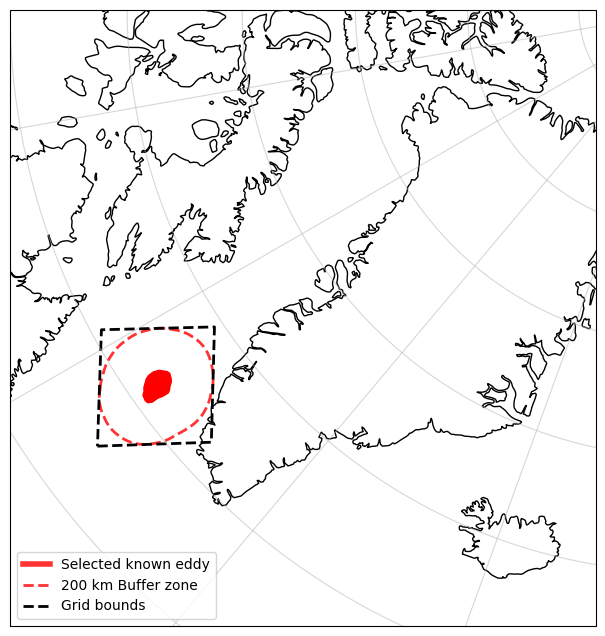

In [ ]:
# We need to define some grids, one for our expert locations and one for our prediction locations
# To help us create a grid in the relevant location and coordinate system, we'll start by making a buffer zone around the eddy and obtain its bounds
buffer = 200e3 #m
buffered_eddy = selected_eddy['geometry'].to_crs('EPSG:6931').iloc[0].buffer(buffer) #note that we must change the polygon crs to get a buffer in metres
minx, miny, maxx, maxy = buffered_eddy.bounds

selected_eddy = selected_eddy.to_crs('EPSG:4326')

#plot the eddy, buffer and the bounds
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-25, -90, 60, 80], crs=ccrs.PlateCarree())
ax.add_geometries([selected_eddy.iloc[0].geometry], crs=ccrs.PlateCarree(), facecolor='red', edgecolor='red')
ax.add_geometries([buffered_eddy], crs=ccrs.epsg(6931), facecolor='none', edgecolor='red', linewidth=2, linestyle='--', alpha=0.8)
buffer_boundary = ax.plot([minx, maxx, maxx, minx, minx], [miny, miny, maxy, maxy, miny], transform=ccrs.epsg(6931), color='black', linestyle='--', linewidth=2, label='Grid bounds')
ax.coastlines()
ax.gridlines(alpha=0.5)
eddy_proxy = mlines.Line2D([], [], color='red', linewidth=4, alpha=0.8, label="Selected known eddy")
buffer_proxy = mlines.Line2D([], [], color='red', linewidth=2, linestyle='--', alpha=0.8, label=f"{int(buffer/1e3)} km Buffer zone")
ax.legend(handles=[eddy_proxy, buffer_proxy, buffer_boundary[0]], loc='lower left')
plt.show()

### Define local experts

In [ ]:
#Make a grid of expert locations using the bounds
expert_grid_res = 25e3
grid_xcs = np.arange(minx, maxx+expert_grid_res/2, expert_grid_res) #remember that the start is included and the stop is not
grid_ycs = np.arange(miny, maxy+expert_grid_res/2, expert_grid_res)
grid_xcs_2d, grid_ycs_2d = np.meshgrid(grid_xcs, grid_ycs)
expert_locs = pd.DataFrame({'x': grid_xcs_2d.flatten(), 'y': grid_ycs_2d.flatten()})
# Add lon and lat
expert_locs['lon'], expert_locs['lat'] = EASE2toWGS84_New(expert_locs['x'], expert_locs['y'], lat_0=90)
expert_locs['t'] = np.floor(sral_df['t'].mean())
# Identify if a position is in the ocean (water) or not
expert_locs["is_in_ocean"] = globe.is_ocean(expert_locs['lat'], expert_locs['lon'])
# keep only prediction locations in ocean
expert_locs = expert_locs.loc[expert_locs["is_in_ocean"]]
print(f'Number of expert locations: {len(expert_locs)}')
print("Local expert locations:")
expert_locs.head()

Number of expert locations: 495
Local expert locations:


<ipython-input-16-4486cd431d78>:8: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  expert_locs['lon'], expert_locs['lat'] = EASE2toWGS84_New(expert_locs['x'], expert_locs['y'], lat_0=90)


x             y        lon        lat        t  is_in_ocean
0 -2.867486e+06 -2.111906e+06 -53.628321  57.656521  17913.0         True
1 -2.842486e+06 -2.111906e+06 -53.388445  57.844369  17913.0         True
2 -2.817486e+06 -2.111906e+06 -53.145834  58.031535  17913.0         True
3 -2.792486e+06 -2.111906e+06 -52.900452  58.218013  17913.0         True
4 -2.767486e+06 -2.111906e+06 -52.652258  58.403793  17913.0         True

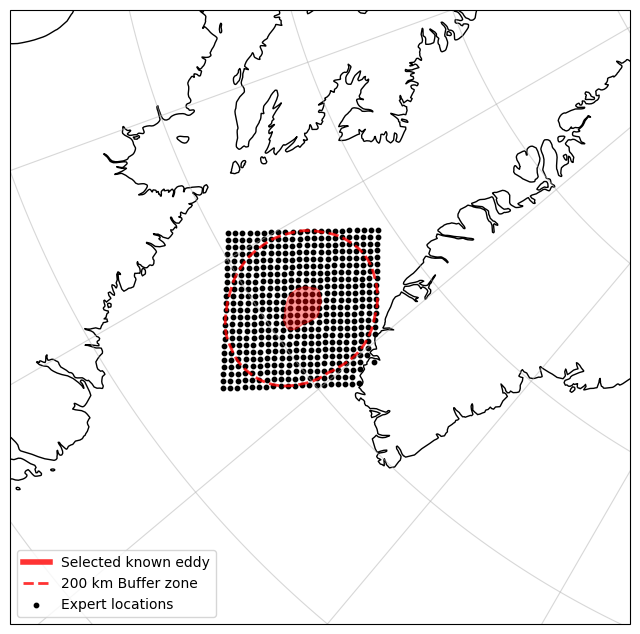

In [ ]:
# Plot the eddy, buffer and the bounds
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-40, -70, 55, 70], crs=ccrs.PlateCarree())
ax.add_geometries(selected_eddy.geometry, crs=ccrs.PlateCarree(), facecolor='red', edgecolor='red', alpha=0.4)
ax.add_geometries([buffered_eddy], crs=ccrs.epsg(6931), facecolor='none', edgecolor='red', linewidth=2, linestyle='--', alpha=0.8)
elocs = ax.scatter(expert_locs['x'], expert_locs['y'], transform=ccrs.epsg(6931), color='black', s=10, label='Expert locations')
ax.coastlines()
ax.gridlines(alpha=0.5)
eddy_proxy = mlines.Line2D([], [], color='red', linewidth=4, alpha=0.8, label="Selected known eddy")
buffer_proxy = mlines.Line2D([], [], color='red', linewidth=2, linestyle='--', alpha=0.8, label=f"{int(buffer/1e3)} km Buffer zone")
ax.legend(handles=[eddy_proxy, buffer_proxy, elocs], loc='lower left')
plt.show()

### Define prediction locations

In [ ]:
#Define a grid for the prediction locations
pred_grid_res = 5e3
pred_grid_xcs = np.arange(minx+pred_grid_res, maxx+pred_grid_res/2, pred_grid_res) #remember that the start is included and the stop is not
pred_grid_ycs = np.arange(miny+pred_grid_res, maxy+pred_grid_res/2, pred_grid_res)
pred_grid_xcs_2d, pred_grid_ycs_2d = np.meshgrid(pred_grid_xcs, pred_grid_ycs)
pred_locs = pd.DataFrame({'x': pred_grid_xcs_2d.flatten(), 'y': pred_grid_ycs_2d.flatten()})
# Add lon and lat columns
pred_locs['lon'], pred_locs['lat'] = EASE2toWGS84_New(pred_locs['x'].values, pred_locs['y'].values, lat_0=90)

<ipython-input-18-3b9a63d0d6f8>:8: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  pred_locs['lon'], pred_locs['lat'] = EASE2toWGS84_New(pred_locs['x'].values, pred_locs['y'].values, lat_0=90)


### Bin observations (to reduce GPSat runtime)

To reduce the number of input data points and ultimately speed up getting some results, we will bin our observations. We will perform drop-in-a-bucket resampling to do this, whereby we average the data that falls within each bin (grid cell)

In [ ]:
#Let us use the grid coordinates that we defined earlier for our prediction locations and use a KDTree to help bin the S3 data within each grid cell
gridded_obvs_dfs = []

for date_val, date_df in sral_df.groupby('t'):
  date_df = date_df.copy()
  gridded_observations = pd.DataFrame({'x': pred_grid_xcs_2d.flatten(), 'y': pred_grid_ycs_2d.flatten()})
  #get the nearest grid cell to each observation
  tree = KDTree(np.vstack([gridded_observations['x'].values, gridded_observations['y'].values]).T)
  distances, indices = tree.query(np.vstack([date_df['x'].values, date_df['y'].values]).T, k=1)
  #nan where dist > max dist
  max_dist = 2.5e3
  indices[distances > max_dist] = -9999
  #get the mean of the observations in each grid cell
  date_df['nearest_grid_cell_index'] = indices
  date_df = date_df.groupby('nearest_grid_cell_index').mean()
  #drop x and y from the averaged date_df as we don't want the mean coords for the grid cell data- we will obtain the actual grid cell x and y when we merge the two datasets
  date_df = date_df.drop(columns=['x', 'y'])
  #merge the binned date_df with the gridded_observations dataframe
  gridded_observations=gridded_observations.merge(date_df, left_index=True, right_index=True, how='left')
  #drop rows with nan ssha values
  ssha_var = 'ssha_20_ku'
  # ssha_var = 'sea_ice_ssha_20_ku'
  gridded_observations = gridded_observations.dropna(subset=[ssha_var])
  #add the t column
  gridded_observations['t'] = date_val
  gridded_obvs_dfs.append(gridded_observations)
  del date_df, gridded_observations, tree, distances, indices

gridded_obvs_df = pd.concat(gridded_obvs_dfs)
gridded_obvs_df = gridded_obvs_df.reset_index(drop=True)

del gridded_obvs_dfs
gridded_obvs_df.head()
print(f'We have reduced the number of observations from {len(sral_df)} to {len(gridded_obvs_df)}')


<ipython-input-19-5922f35496c4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gridded_observations['t'] = date_val
<ipython-input-19-5922f35496c4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gridded_observations['t'] = date_val


We have reduced the number of observations from 153030 to 2466


In [ ]:
sral_df = sral_df.dropna(subset=['x', 'y', 't','ssha_20_ku']).reset_index(drop=True)
print(sral_df.shape)

### Set GPSat configuration parameters

In [ ]:
# Set training and inference radius
training_radius = 100_000
inference_radius = 50_000

In [ ]:
# Local expert locations config
local_expert = ExpertLocsConfig(source = expert_locs)

# Model config
model = ModelConfig(oi_model = "GPflowSGPRModel", # Use GPflow SGPR model
# model = ModelConfig(oi_model = "GPflowGPRModel", # Use GPflow GPR model
                    init_params = {
                        # normalise xy coordinates
                        "coords_scale": [10_000, 10_000, 1],
                        'num_inducing_points':100
                        },
                    constraints = {
                        # set bounds on the lengthscale hyperparameters
                        "lengthscales": {
                            "low": [1e-08, 1e-08, 1e-08],
                            "high": [600_000, 600_000, 9]
                        }
                        }
                    )

# Data config
data = DataConfig(data_source = sral_df,
                  obs_col = ssha_var,
                  coords_col = ["x", "y", "t"],
                  local_select = [
                    # Select data within the training window and radius
                    {"col": "t", "comp": "<=", "val": training_window.days},
                    {"col": "t", "comp": ">=", "val": -training_window.days},
                    {"col": ["x", "y"], "comp": "<", "val": training_radius}
                  ]
                )

# Prediction locs config
pred_loc = PredictionLocsConfig(method = "from_dataframe",
                                df = pred_locs,
                                max_dist = inference_radius)

In [ ]:
locexp = LocalExpertOI(expert_loc_config = local_expert,
                       data_config = data,
                       model_config = model,
                       pred_loc_config = pred_loc)

in json_serializable - key: 'source' has value DataFrame/Series, but is too long: 495 >  100
storing as str
'data_select': 0.001 seconds
'load': 0.001 seconds
in json_serializable - key: 'data_source' has value DataFrame/Series, but is too long: 2466 >  100
storing as str
in json_serializable - key: 'df' has value DataFrame/Series, but is too long: 11766 >  100
storing as str


### Run GPSat

In [ ]:
# path to store results
store_path = week8_path / 'OI_results' / f'Eddy_num_{eddy_number}_{date.strftime("%Y-%m-%d")}_{ssha_var}.h5'
if store_path.parent.exists() == False:
    store_path.parent.mkdir(parents=True)

In [ ]:
# for the purposes of a simple example, if store_path exists: delete it
if os.path.exists(store_path):
    cprint(f"removing: {store_path}")
    os.remove(store_path)

# run optimal interpolation
locexp.run(store_path=str(store_path))

Streaming output truncated to the last 5000 lines.
'optimise_parameters': 0.873 seconds
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([13.76382547,  4.58616132,  2.48405714]) 
kernel_variance: 0.005845132444405152
likelihood_variance: 0.0011317213965883514
'predict': 0.099 seconds
total run time : 2.57 seconds
--------------------------------------------------
238 / 495
current local expert:
                x             y        lon        lat        t  is_in_ocean
248 -2.717486e+06 -1.836906e+06 -55.942964  60.276206  17913.0         True
'local_data_select': 0.003 seconds
number obs: 280
setting lengthscales to: [1. 1. 1.]
'__init__': 0.036 seconds
'set_lengthscales_constraints': 0.008 seconds
'optimise_parameters': 0.955 seconds
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([4.25852907e+01, 4.32898608e+00, 2.34274228e-02]) 
kernel_variance: 0.004000643813710293
likelihood_variance: 0.0011587707621332902
'predict': 0.098 seconds
total run time : 2

### Glue initial results

In [ ]:
# extract, store in dict
dfs, _ = get_results_from_h5file(store_path)

print(f"tables in results file: {list(dfs.keys())}")

reading in results
getting all tables
merging on expert location data
table: 'oi_config' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
tables in results file: ['expert_locs', 'kernel_variance', 'lengthscales', 'likelihood_variance', 'oi_config', 'preds', 'run_details']


In [ ]:
preds_data = dfs["preds"]
preds_data.head()
inference_radius = 50_000
# multiple local experts may make predictions at the same prediction location (pred_loc).
# - for each prediction at a given location, take we weighted combination
# - weights being a function of the distance to each local expert that made a prediction at a given location.
plt_data = glue_local_predictions_2d(preds_df=preds_data,
                                     pred_loc_cols=["pred_loc_x", "pred_loc_y"],
                                     xprt_loc_cols=["x", "y"],
                                     vars_to_glue=["f*", "f*_var"],
                                     inference_radius=inference_radius)
plt_data['lon'],plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'],plt_data['pred_loc_y'],lat_0=90)
#Set to nan predictions that are not over the ocean
plt_data['is_ocean'] = globe.is_ocean(plt_data['lat'], plt_data['lon'])
plt_data.loc[plt_data['is_ocean'] == False, 'f*'] = np.nan
plt_data.head()

<ipython-input-26-b5e1824e6ef0>:12: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  plt_data['lon'],plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'],plt_data['pred_loc_y'],lat_0=90)


pred_loc_x    pred_loc_y        f*    f*_var        lon        lat  \
0 -2.862486e+06 -2.106906e+06  0.001823  0.000695 -53.645422  57.721871   
1 -2.862486e+06 -2.101906e+06  0.001931  0.000839 -53.710389  57.749552   
2 -2.862486e+06 -2.096906e+06  0.001677  0.000975 -53.775465  57.777188   
3 -2.862486e+06 -2.091906e+06  0.000999  0.001076 -53.840650  57.804780   
4 -2.862486e+06 -2.086906e+06  0.000035  0.001128 -53.905942  57.832326   

   is_ocean  
0      True  
1      True  
2      True  
3      True  
4      True

## Visualise OI results

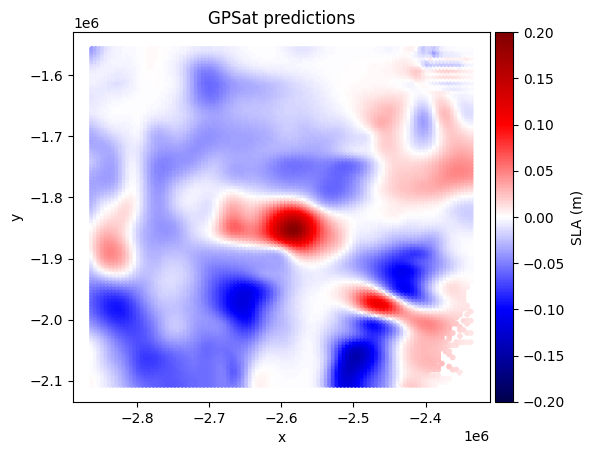

In [ ]:
fig, ax = plt.subplots()
sla_preds = ax.scatter(plt_data['pred_loc_x'],plt_data['pred_loc_y'],c=plt_data['f*'],s=10,cmap='seismic',vmin=-0.2,vmax=0.2)
fig.colorbar(sla_preds, ax=ax, label='SSHA (m)', pad=0.01)
ax.set_title('GPSat predictions')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()


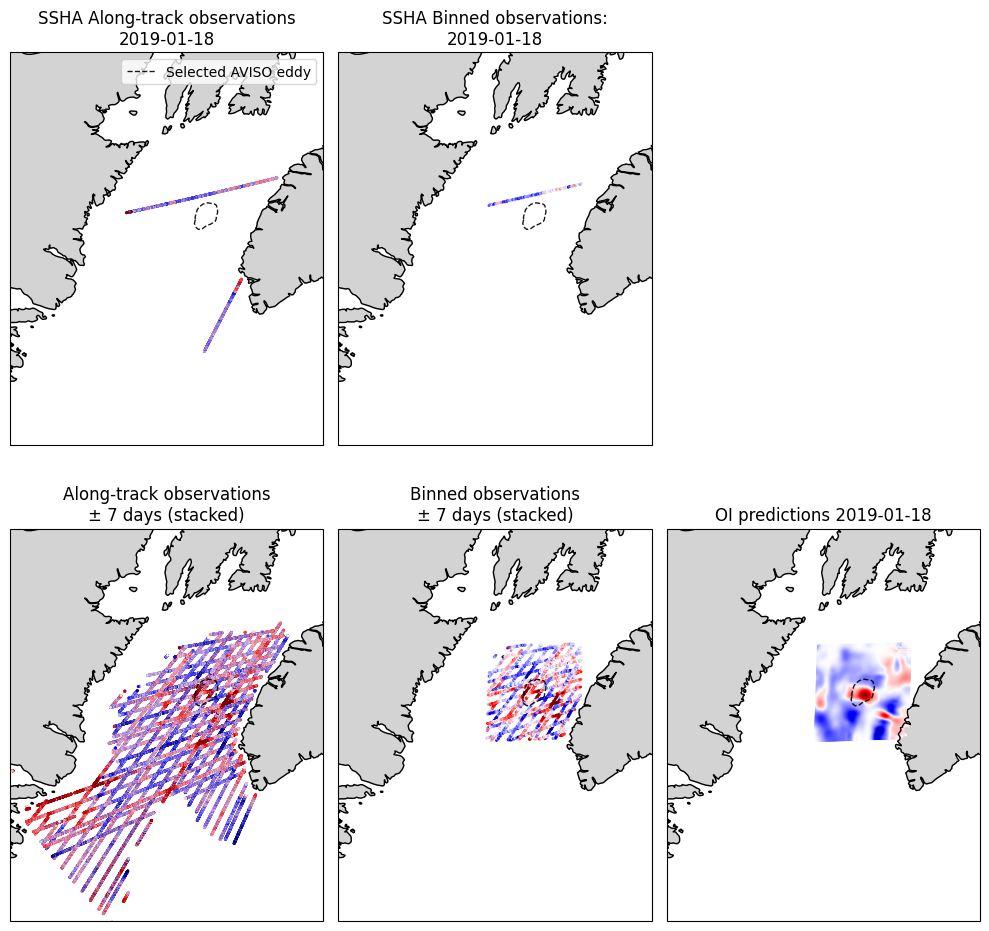

In [ ]:
fig,axs = plt.subplots(2,3,figsize=(10,10),subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
axs = axs.flatten()
eddy_proxy = mlines.Line2D([], [], color='black', linestyle='--', linewidth=1, alpha=0.9, label="Selected AVISO eddy")

for i, ax in enumerate(axs):
    if i == 2:
        continue # We will leave ax[2] empty
    ax.set_extent([-35, -75, 55, 60], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_geometries(
    selected_eddy['geometry'], crs=ccrs.PlateCarree(),
    facecolor="none", edgecolor="black", linewidth=1, linestyle='--', alpha=0.9, zorder=100)


axs[0].scatter(sral_ds.where(sral_ds.time_20_ku.dt.date == selected_eddy['time'].values[0].astype("datetime64[D]"))['lon_20_ku'],\
               sral_ds.where(sral_ds.time_20_ku.dt.date == selected_eddy['time'].values[0].astype("datetime64[D]"))['lat_20_ku'],\
               c=sral_ds.where(sral_ds.time_20_ku.dt.date == selected_eddy['time'].values[0].astype("datetime64[D]"))['ssha_20_ku'],\
               s=1, cmap='seismic', vmin=-0.2, vmax=0.2, transform=ccrs.PlateCarree())
axs[0].set_title(f'SSHA Along-track observations\n{selected_eddy["time"].values[0].astype("datetime64[D]")}')
axs[0].legend(handles=[eddy_proxy], loc='lower left', fontsize=10)

axs[1].scatter(gridded_obvs_df[gridded_obvs_df['t'] == selected_eddy['time'].values[0].astype("datetime64[D]").astype(float)]['x'],\
                gridded_obvs_df[gridded_obvs_df['t'] == selected_eddy['time'].values[0].astype("datetime64[D]").astype(float)]['y'],\
                c=gridded_obvs_df[gridded_obvs_df['t'] == selected_eddy['time'].values[0].astype("datetime64[D]").astype(float)]['ssha_20_ku'],\
                s=1, cmap='seismic', vmin=-0.2, vmax=0.2, transform=ccrs.epsg(6931))
axs[1].set_title(f'SSHA Binned observations:\n{selected_eddy["time"].values[0].astype("datetime64[D]")}')

axs[2].axis('off')

axs[3].scatter(sral_df['lon_20_ku'],sral_df['lat_20_ku'],c=sral_df['ssha_20_ku'],s=1,cmap='seismic',vmin=-0.2,vmax=0.2,transform=ccrs.PlateCarree())
axs[3].set_title(f'Along-track observations\n± {training_window.days} days (stacked)')

axs[4].scatter(gridded_obvs_df['x'],gridded_obvs_df['y'],c=gridded_obvs_df['ssha_20_ku'],s=1,cmap='seismic',vmin=-0.2,vmax=0.2, transform=ccrs.epsg(6931))
axs[4].set_title(f'Binned observations\n± {training_window.days} days (stacked)')

axs[5].scatter(plt_data['lon'],plt_data['lat'],c=plt_data['f*'],s=1,cmap='seismic',vmin=-0.2,vmax=0.2,transform=ccrs.PlateCarree())
axs[5].set_title(f'OI predictions {selected_eddy["time"].values[0].astype("datetime64[D]")}')
plt.tight_layout()
plt.show()

Qualitatively, we have been able to construct an SSH field using optimal interpolation that appears to capture well the known eddy in terms of its position and height. This is despite not having a single direct overpass on the date of interest.

The next step would be to process this SSH field to extract the eddy bounds and more of its characteristics (vorticity, inner height vs effective height, etc). See literature such as: Mason, E., A. Pascual, and J. C. McWilliams, 2014: A New Sea Surface Height–Based Code for Oceanic Mesoscale Eddy Tracking. J. Atmos. Oceanic Technol., 31, 1181–1188, https://doi.org/10.1175/JTECH-D-14-00019.1 and its associated python package, https://py-eddy-tracker.readthedocs.io/en/latest/python_module/index.html, for the steps taken to do achieve this.